#  Lightcurves, transits, and TESS! Oh My!

Assumed knowledege:

1. CCD operation and structure
2. Point-spread functions
3. Plotting tools
4. Model fitting

### Step 0: imports

In [1]:
# these should be familar
import scipy
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

# this package will allow us to make progress bars
from tqdm import tqdm

# We can beautify our plots by changing the matpltlib setting a little
plt.rcParams['font.size'] = 18
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['font.family'] = "serif"

# Step 1: fetch the data

In [2]:
# this function downloades TESS lightcurves (I recommend we supply this function 
# and have the student's use it as a black box)

def load_TESS_data(target, cutout_size=20, verbose=False, exptime=None):
    """
    Download TESS images for a given target.
    
    inputs:
        target: str, same of star (ex. TOI-700)
        cutout_size: int, size of the returned cutout 
                     (in units of pixels)
        verbose: bool, controls whether to include printouts
        exptime: str, determines if we use short or long cadence mode
                 (if None, defaults to first observing semester)
    outputs:
        time: numpy 1D array
        flux: numpy 3D array (time x cutout_size x cutout_size)
    """
    
    import lightkurve as lk
    
    # find all available data
    search_result = lk.search_tesscut(target)
    if exptime == 'short':
        search_result = search_result[search_result.exptime.value==search_result.exptime.value.min()]
    elif exptime == 'long':
        search_result = search_result[search_result.exptime.value==search_result.exptime.value.max()]
    print(search_result)
        
    # select the first available observing sector
    if exptime:
        search_result = search_result[search_result.exptime == exptime]
    search_result = search_result[search_result.mission == search_result.mission[0]]

    # download it
    tpf = search_result.download_all(cutout_size=cutout_size)[0]
    
    # convert it to a numpy array format
    flux = np.array([
        tpf.flux[i].value for i in range(len(tpf.flux)) if tpf.flux[i].value.min()>0
    ])
    flux_err = np.array([
        tpf.flux_err[i].value for i in range(len(tpf.flux_err)) if tpf.flux[i].value.min()>0
    ])

    time = np.array([ 
        tpf.time.value[i] for i in range(len(tpf.flux)) if tpf.flux[i].value.min()>0 
                    ])
    
    return time, flux, flux_err

### Let's load all the TESS data for one small patch of the sky. We'll center our images on a single variable star.

In [3]:
target = 'Gaia_DR2279382060625871360'
cutout_size = 20 # dimensions of the image in pixels x pixels
time, flux, flux_err = load_TESS_data(target,verbose=True,cutout_size=cutout_size)

/Users/siegeljc/miniconda3/lib/python3.11/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/siegeljc/.lightkurve/cache. Please move all the files in the legacy directory /Users/siegeljc/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


SearchResult containing 3 data products.

 #     mission     year  author exptime        target_name         distance
                                   s                                arcsec 
--- -------------- ---- ------- ------- -------------------------- --------
  0 TESS Sector 19 2019 TESScut    1426 Gaia_DR2279382060625871360      0.0
  1 TESS Sector 59 2022 TESScut     158 Gaia_DR2279382060625871360      0.0
  2 TESS Sector 73 2023 TESScut     158 Gaia_DR2279382060625871360      0.0


In [4]:
# how many images are available?
print(time.shape, flux.shape)

(1150,) (1150, 20, 20)


# Step 2: visualize the data

Let's plot some of these images!

In [5]:
def plot_cutout(image, logscale = False, vrange = [1,99]):
    """
    Plot 2D image.
    
    inputs:
        image: 2D numpy array
        logscale: bool, if True plots np.log10(image)
        vrnge: list, sets range of colorbar 
               (based on percentiles of 'image') 
    """
    if logscale:
        image = np.log10(image)
        
    q = np.percentile(image, q = vrange)
    plt.imshow( image, vmin = q[0], vmax = q[1] )    
    plt.show()

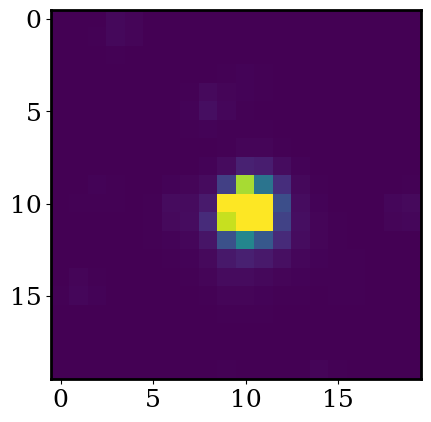

In [6]:
# linear scale
plot_cutout(np.mean(flux,axis=0))

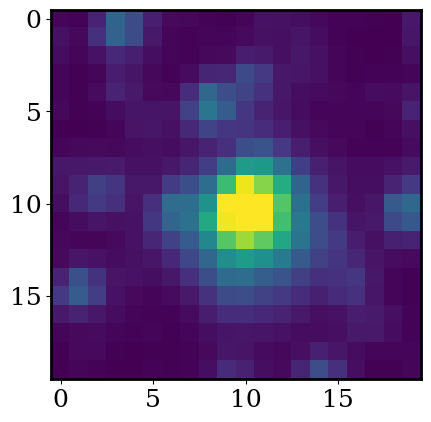

In [7]:
# log scale
plot_cutout(np.mean(flux,axis=0),logscale=True)

# Step 3: Let's make a lightcurve

We want to measure the flux of the star in each image. We can then see how the star's flux changes with time. This allows us to study binary stars, exoplanets, and stellar pulsations (like Earthquakes but on stars).

### The simplest option is to take the sum all pixels in image:

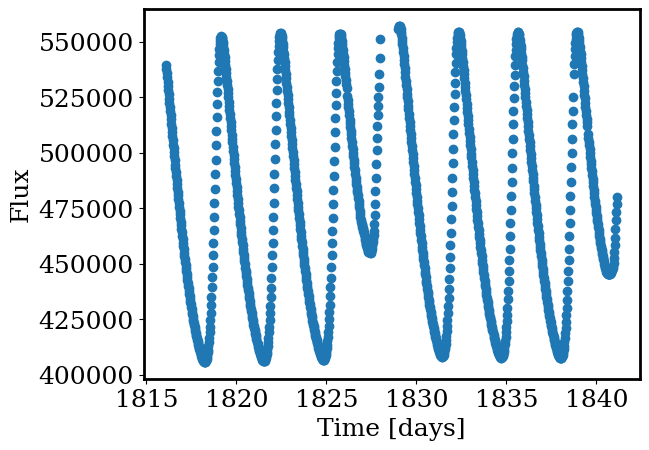

In [8]:
sums = np.array([np.sum(f) for f in flux])

plt.scatter(time,sums)

_ = plt.xlabel('Time [days]')
_ = plt.ylabel('Flux')

# How can we make a better lightcurve?


We can see this area of the sky is populated by more than one star (this is especially clear when we plot in log scale). This is very common occurance. 

Because the image includes more than one star, simply taking the sum of all pixels in the image will not give us a very accurate number for the flux of the star we're intersted in. We also have to be careful about the background flux changing with time due to instrumental systematics.

A common method of overcoming these challenges is fitting the image with a two component model: background + star.

Since the star is being 'blurred' by the point spread function of TESS, we can reasonably model the star as a 2-dimensional Gaussian.

To keep things simple, let's assume a uniform background. 

In [9]:
def psf(x,y,sigma,scale,bkg,xmu=0,ymu=0,unravel=False):
    """
    Symmetric 2D point-spread function (PSF)
    
    inputs:
        x: np.ndarray, where to evaluate the PSF
        y: np.ndarray, where to evaluate the PSF
        sigma: float, width of the PDF
        scale: float, integrated area under the PSF
        bkg: float, background flux level
        xmu: float, center of PSF in x
        ymu: float, center of PSF in y
    outputs:
        PSF evalauted at x and y
    """
    exponent = (np.power(x-xmu,2) + np.power(y-ymu,2) ) / sigma**2
    
    mod = scale * np.exp(-exponent) / (2*np.pi*sigma**2) + bkg
    if unravel:
        return mod.ravel()
    else:
        return mod

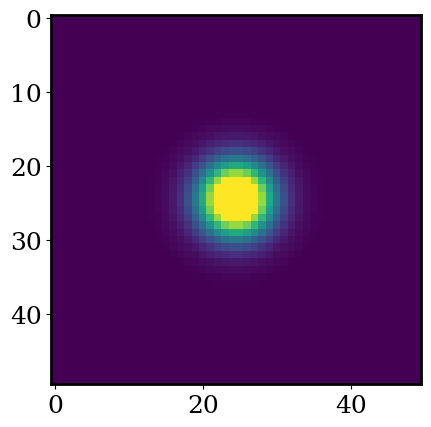

In [10]:
# lets plot one
x = np.linspace(0,10,50)
y = np.linspace(0,10,50)
X, Y = np.meshgrid(x, y)
Z = psf(X,Y,sigma=1,scale=1,bkg=0,xmu=5,ymu=5)

plot_cutout(Z,logscale=False)

We now have the ingredients for our model. To fit our model we need to quantify 'goodness of fit.'

Let's start by calculating the residual between a given image and our model.

In [11]:
def residual(theta, x, y, z, z_err, sumit = False):
    sigma, scale, bkg, xmu, ymu = theta
    
    model = psf(x,y,sigma=sigma,scale=scale,bkg=bkg,xmu=xmu,ymu=ymu)
    
    chi = np.power(model - z,2)/z_err**2
    
    if sumit:
        return np.sum(chi)
    else:
        return chi.ravel()

In [12]:
# where to evaluate our PSF
x = np.arange(flux.shape[1])
y = np.arange(flux.shape[2])
X,Y = np.meshgrid(x,y)

In [13]:
# lets evaluate the model for a set of parameters
theta = [
    1,  # sigma
    200,  # scale
    0,  # bkg
    cutout_size/2, # xmu
    cutout_size/2, # ymu
]

residual(theta, X, Y, flux[0]/np.mean(flux), flux_err[0]/np.mean(flux), sumit=True)

415386221.45279515

Using our residual function, we can now ask: what parameters (like stellar flux) best fit the image? To give some intuition, let's start with a simple grid search.

In [14]:
# let's vary the 'scale' parameter to see what works best
scales = np.linspace(0,1000,100)
residuals = []
for scale in scales:
    theta = [
        1,  # sigma
        scale,  # scale
        0,  # bkg
        cutout_size/2, # xmu
        cutout_size/2, # ymu
    ]

    residuals.append( residual(theta, X, Y, flux[0]/np.mean(flux), flux_err[0]/np.mean(flux),sumit=True) )

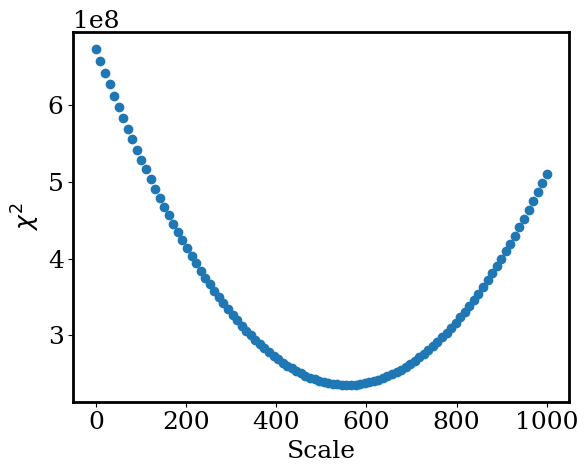

In [15]:
plt.scatter(scales,residuals)
_ = plt.xlabel('Scale')
_ = plt.ylabel('$\chi^2$')

Let's now repeat that process for each image to construct a lightcurve.

In [16]:
manual_lightcurve = []
for i in tqdm(range(len(flux))):
    # let's vary the 'scale' parameter to see what works best
    scales = np.linspace(0,1000,100)
    residuals = []
    for scale in scales:
        theta = [
            1,  # sigma
            scale,  # scale
            0,  # bkg
            cutout_size/2, # xmu
            cutout_size/2, # ymu
        ]

        residuals.append( residual(theta, X, Y, flux[i]/np.mean(flux), flux_err[i]/np.mean(flux), sumit=True) )
        
    manual_lightcurve.append( scales[np.argmin(residuals)] )

100%|███████████████████████████████████████| 1150/1150 [00:21<00:00, 53.27it/s]


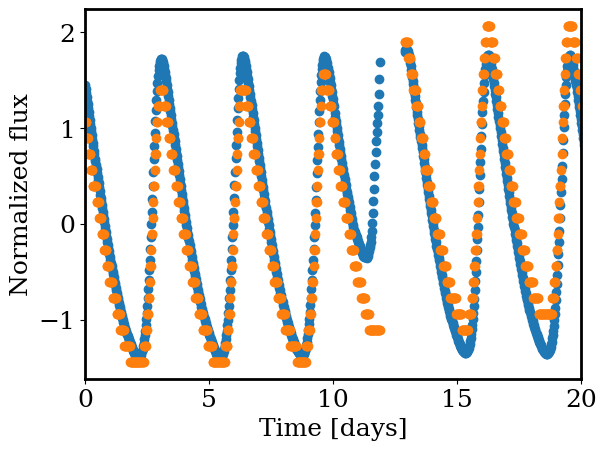

In [17]:
plt.scatter(time-time.min(), (sums - np.mean(sums))/np.std(sums) )
plt.scatter(time-time.min(), (manual_lightcurve - np.mean(manual_lightcurve))/np.std(manual_lightcurve) )

plt.xlim([0,20])
_ = plt.xlabel('Time [days]')
_ = plt.ylabel('Normalized flux')

As we discussed in class, we can optimize our model using least squares regression. This is both faster than grid searches and gives us an estimate of the model uncertainty.

In [18]:
import scipy
lightcurve = []
lightcurve_err = []

for i,f in tqdm(enumerate(flux)):
    # total flux?
    out = scipy.optimize.leastsq(residual, 
                              x0 = [
                                    1, 
                                    6*(f/np.mean(flux)).max(),  
                                    np.median(f/np.mean(flux)),  
                                    cutout_size/2,  
                                    cutout_size/2],
                              args = (X,Y,f/np.mean(flux),flux_err[i]/np.mean(flux)),
                              full_output = True
                                )
    lightcurve.append( out[0][1] )
    lightcurve_err.append( np.sqrt(np.diag(out[1]))[1] )
    
lightcurve     = np.array(lightcurve)
lightcurve_err = np.array(lightcurve_err)

1150it [00:03, 309.69it/s]


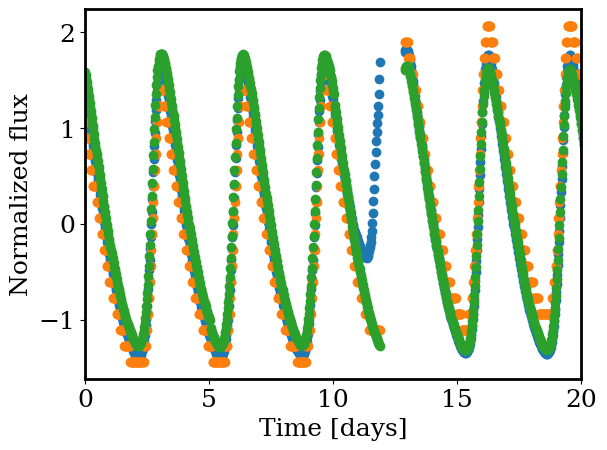

In [19]:
plt.scatter(time-time.min(), (sums - np.mean(sums))/np.std(sums) )
plt.scatter(time-time.min(), (manual_lightcurve - np.mean(manual_lightcurve))/np.std(manual_lightcurve) )
plt.scatter(time-time.min(), (lightcurve - np.mean(lightcurve))/np.std(lightcurve) )

plt.xlim([0,20])
_ = plt.xlabel('Time [days]')
_ = plt.ylabel('Normalized flux')

# Step 4: finding the pulsation period

We've now successfully made a lightcurve for our star! By eye we can see the star is **variable** (it's flux is periodically varying with time). How long does it take to complete a cycle?

Let's start by simply fitting the lightcurve with a simple periodic function: a sine wave. 

Try changing the amplitude, period, and phase to best fit the observed lightcurve.

Notice the star's oscillations are not perfectly sinusoidal.

In [20]:
def sinusoid_model(time,ampl,period,phase,background):
    omega = 2 * np.pi / period
    return ampl * np.sin( time * omega + phase ) + background

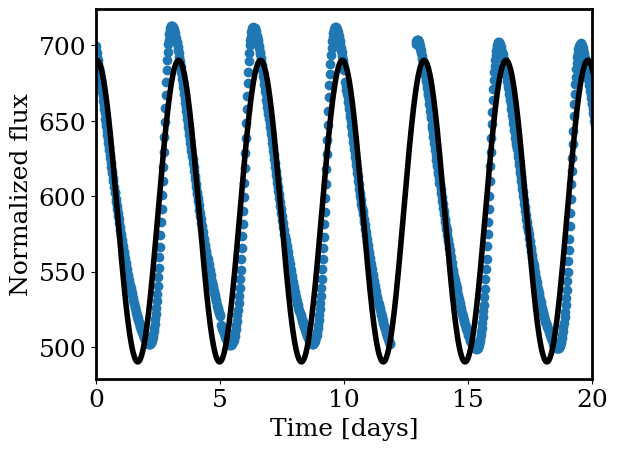

In [21]:
tp = np.linspace(0,time.max()-time.min(),1000)

plt.scatter(time-time.min(), lightcurve)
plt.plot(tp, sinusoid_model(tp, *[
                                100, # amplitude
                                3.3, # period (days)
                                1.5, # phase (radians, between 0 and 2 pi)
                                np.mean(lightcurve)
                          ]),color='k',linewidth=4 )

plt.xlim([0,20])
_ = plt.xlabel('Time [days]')
_ = plt.ylabel('Normalized flux')

Now let's try automating the process. For a grid of periods and phases, calculate the goodness of fit.

In [22]:
periods = np.linspace(1,5,10)
phases  = np.linspace(0,2*np.pi,10)

period_grid, phase_grid = np.meshgrid(periods,phases)

chi = np.ones_like(period_grid)

for i,period in enumerate(periods):
    for j,phase in enumerate(phases):
        model = sinusoid_model(time,100,period,phase,np.mean(lightcurve))
        
        chi[j][i] = np.sum(np.power(lightcurve-model,2) )

In [23]:
best_index  = np.argmin(chi.ravel())
best_period_grid = period_grid.ravel()[best_index]
best_phase_grid  = phase_grid.ravel()[best_index]

print(f'Best: {best_period_grid:.3} days')

Best: 3.22 days


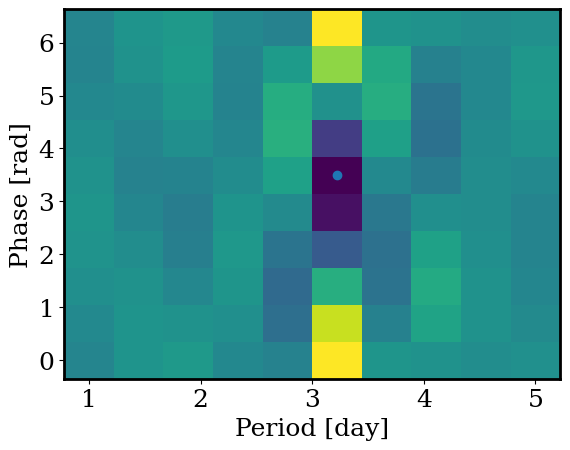

In [24]:
_=plt.pcolormesh(period_grid, phase_grid, chi)
_=plt.scatter(best_period_grid,best_phase_grid)

_=plt.xlabel('Period [day]')
_=plt.ylabel('Phase [rad]')

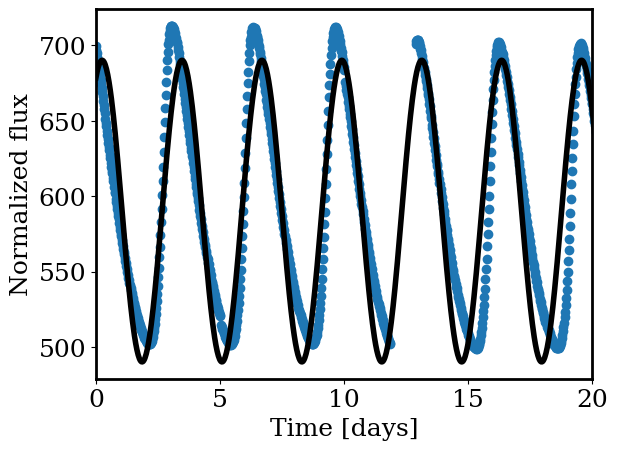

In [25]:
tp = np.linspace(time.min(),time.max(),1000)

plt.scatter(time-time.min(), lightcurve)
plt.plot(tp-time.min(), sinusoid_model(tp, *[
                                100, # amplitude
                                best_period_grid, # period (days)
                                best_phase_grid, # phase (radians, between 0 and 2 pi)
                                np.mean(lightcurve)
                          ]),color='k',linewidth=4 )

plt.xlim([0,20])
_ = plt.xlabel('Time [days]')
_ = plt.ylabel('Normalized flux')

Our sine model works okay but certainly isn't a perfect fit to the data. Instead let's try a Lomb-Scargle periodogram. This method finds the periodic signals in a dataset using Fourier transforms. See: https://iopscience.iop.org/article/10.3847/1538-4365/aab766/pdf

(don't think we need to dive into the weeds too much on Lomb-Scargle if we have everyone build intuition from the sine fitting?-JS)

In [26]:
from astropy.timeseries import LombScargle

periods   = 10**np.linspace(np.log10(2),2,1000)
frequency = 1/periods
power = LombScargle(time,lightcurve).power(frequency)

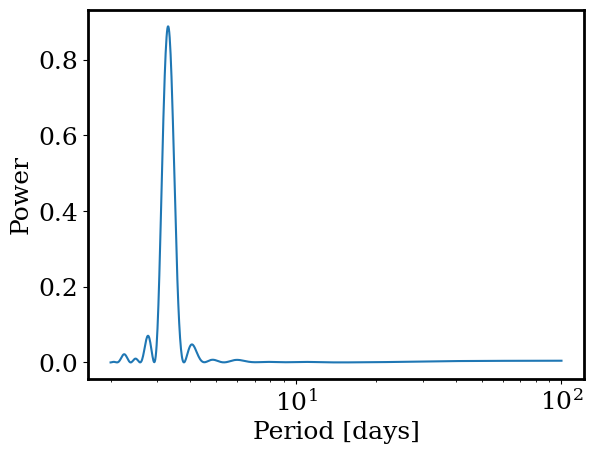

In [27]:
plt.plot(periods,power)
_ = plt.xlabel('Period [days]')
_ = plt.ylabel('Power')
plt.xscale('log')

In [28]:
best_period = periods[np.argmax(power)]
print(f'Best: {best_period:.3} days')

Best: 3.29 days


# Step 6: finding planets

Above we measured the lightcurve for a star from TESS and then calculated it's oscillation period. Let's now repeat that process for a star known to host a transiting planet!

In [29]:
def extract_lightcurve(time, flux, flux_err):
    
    x = np.arange(flux.shape[1])
    y = np.arange(flux.shape[2])
    X,Y = np.meshgrid(x,y)

    lightcurve = []
    lightcurve_err = []
    for i,f in tqdm(enumerate(flux)):
        # total flux?
        out = scipy.optimize.leastsq(residual, 
                                  x0 = [
                                        1, 
                                        6*(f/np.mean(flux)).max(),  
                                        np.median(f/np.mean(flux)),  
                                        cutout_size/2,  
                                        cutout_size/2],
                                  args = (X,Y,f/np.mean(flux),flux_err[i]/np.mean(flux)),
                                  full_output = True
                                    )
        lightcurve.append( out[0][1] )
        lightcurve_err.append( np.sqrt(np.diag(out[1]))[1] )

    
    return np.array(lightcurve), np.array(lightcurve_err)

def get_max_period(x, y, plot_it=False, l = 2, h = 100):
    from astropy.timeseries import LombScargle
    
    periods = 10**np.linspace(np.log10(l),np.log10(h),1000)
    frequency = 1/periods
    power = LombScargle(x,y).power(frequency)
    
    if plot_it:
        plt.plot(periods,power)
        plt.xscale('log')
        _ = plt.xlabel('Period [days]')
        _ = plt.ylabel('Power')
        plt.show()
    
    return periods[np.argmax(power)]

def plot_lightcurve(x,y):
    plt.scatter(x, y)
    _ = plt.xlabel('Time [days]')
    _ = plt.ylabel('Normalized flux')
    plt.show()
    
def median_filter(x,y,width):
    smooth = []
    for xi in x:
        C = np.abs(xi-x)<width/2
        smooth.append(np.median(y[C]))
    return np.array(smooth)

Let's start with a relatively bright star hosting a Jupiter sized planet:

In [30]:
target = 'Gaia_DR24624979393181971328'

period_tess = 2.084544 # days
radius_planet_tess = 1.286 # R_jup
radius_star_tess   = 1.17 # R_sun

Similar to the variable star we studied above, let's load the TESS data and extract the lightcurve.

In [31]:
cutout_size = 20 # dimensions of the image in pixels x pixels

storage = {}

# stamps
time, flux, flux_err = load_TESS_data(target,verbose=True,cutout_size=cutout_size,exptime=158)

# to lightcurve
lc, lc_err = extract_lightcurve(time, flux, flux_err)

# median filter
smooth = median_filter(time,lc,1)    

# save it
storage[target] = {}
storage[target]['time'] = time
storage[target]['flux'] = flux    
storage[target]['flux_err'] = flux_err

storage[target]['lc'] = lc    
storage[target]['lc_err'] = lc_err
storage[target]['smooth'] = smooth    

SearchResult containing 34 data products.

 #     mission     year  author exptime         target_name         distance
                                   s                                 arcsec 
--- -------------- ---- ------- ------- --------------------------- --------
  0 TESS Sector 06 2018 TESScut    1426 Gaia_DR24624979393181971328      0.0
  1 TESS Sector 05 2018 TESScut    1426 Gaia_DR24624979393181971328      0.0
  2 TESS Sector 04 2018 TESScut    1426 Gaia_DR24624979393181971328      0.0
  3 TESS Sector 03 2018 TESScut    1426 Gaia_DR24624979393181971328      0.0
  4 TESS Sector 01 2018 TESScut    1426 Gaia_DR24624979393181971328      0.0
  5 TESS Sector 02 2018 TESScut    1426 Gaia_DR24624979393181971328      0.0
  6 TESS Sector 13 2019 TESScut    1426 Gaia_DR24624979393181971328      0.0
...            ...  ...     ...     ...                         ...      ...
 27 TESS Sector 66 2023 TESScut     158 Gaia_DR24624979393181971328      0.0
 28 TESS Sector 65 2023 TESScut  

980it [00:02, 382.95it/s]


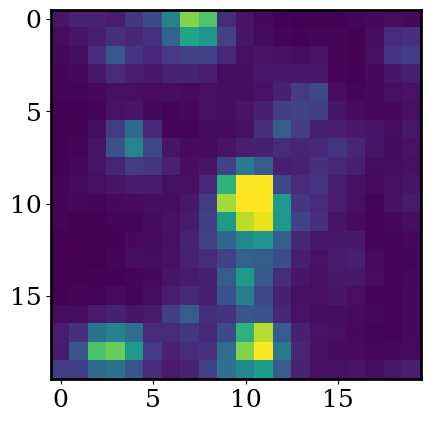

In [32]:
# log scale
plot_cutout(np.median(flux,axis=0),logscale=True)

Next let's clean the lightcurve. We want to 1) mask the observations with strong intrsumental systematics and 2) estimate the star's out of transit flux with a median filter.

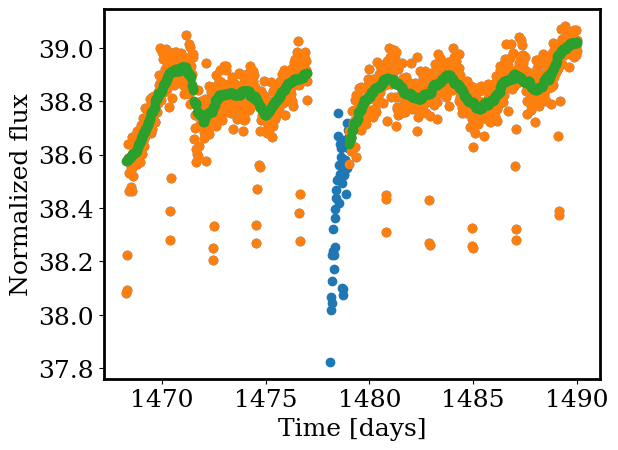

In [33]:
# load it
time   = storage[target]['time']
lc     = storage[target]['lc']
smooth = storage[target]['smooth']

# cut it
C = np.abs(time - 1478) > 1

# plot
plt.scatter(time, lc)
plt.scatter(time[C], lc[C])
plt.scatter(time[C], smooth[C])

_ = plt.xlabel('Time [days]')
_ = plt.ylabel('Normalized flux')
plt.show()

# save it
storage[target]['time_clean']   = time[C]
storage[target]['lc_clean']     = lc[C] / smooth[C] # it's much easier to work in terms of relative flux
storage[target]['lc_err_clean'] = storage[target]['lc_err'][C] / smooth[C]

Because the planet is so large, we can clearly see the transits!

Let's now use the Lomb-Scargle periodogram to find the planet's period.

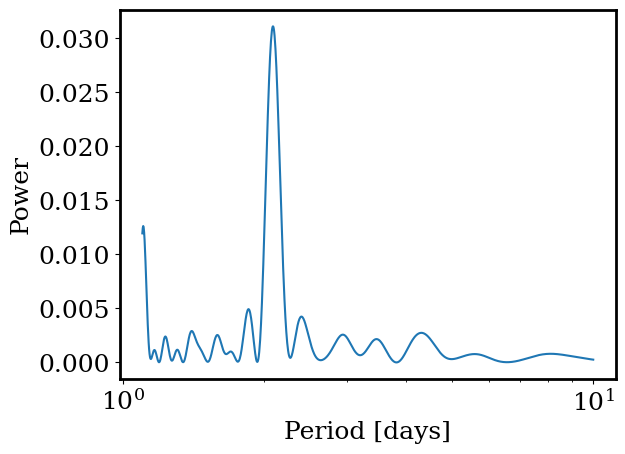

Found period: 2.083 days
Published period: 2.085 days


In [34]:
period = get_max_period(storage[target]['time_clean'], storage[target]['lc_clean'], 
               plot_it=True, l = 1.1, h = 10)

print(f'Found period: {period:.4} days')
print(f'Published period: {period_tess:.4} days')

We now have a clean lightcurve and a good guess at the planet's orbit period. 

We can now determine when the planet's orbital properties more precisely. To start, let's determine when the transits occur. Unfortunately, this is difficult to measure for individual transits because of how sparsely sampled the events are. 

We can overcome this challenge by combining the individual transits into one 'average' transit. Let's first crudely estimate the transit times.

In [35]:
# load it
time   = storage[target]['time_clean']
lc     = storage[target]['lc_clean']
lc_err = storage[target]['lc_err_clean']

In [36]:
# first transit
C  = time-time.min()<period
t0 = time[C][ np.argmin(lc[C]) ] # cheap first transit time
transit_times = [t0]
transit_num  = 0
transit_nums = [transit_num]

# following transit times
while t0 < time.max():
    C = np.abs(time - t0) < 0.05

    if len(C[C])>0:
        transit_times.append(time[C][ np.argmin(lc[C]) ])    
        transit_nums.append(transit_num)
    
    transit_num += 1
    t0 += period

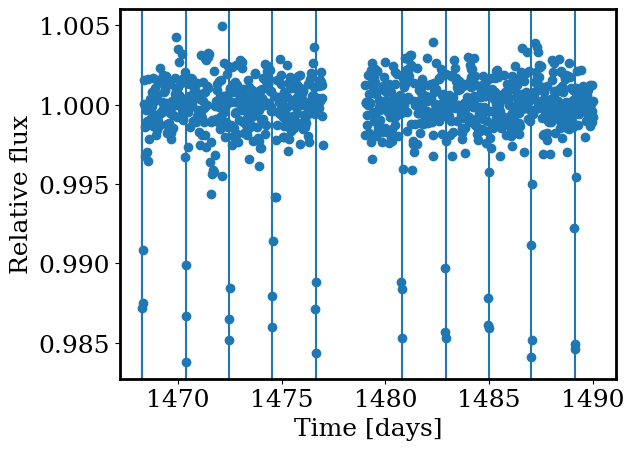

In [37]:
plt.scatter(time,lc)
for t in transit_times:
    plt.axvline(t)
_=plt.xlabel('Time [days]')
_=plt.ylabel('Relative flux')

Since the planet's orbital period is constant, the transit times should follow a simple formula:
$$ T(n) = T_0 + P \times n $$
where $T(n)$ is the $n$th transit time (i.e., $n=0,1,2,\dots$), $T_0$ is the first observed transit time, and $P$ is the orbital period.

Based on this, we can measure $T_0$ and $P$ by fitting a linear function to the crude transit times we measured above.

Phase: 1468.3 days
Period: 2.086 days


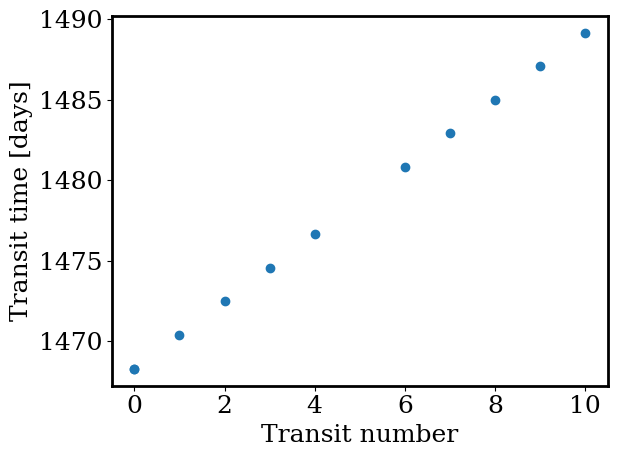

In [38]:
def linear(x,m,b):
    return m*x+b

popt,pcov = scipy.optimize.curve_fit(linear, transit_nums, transit_times)

period_fit, phase = popt

_=plt.scatter(transit_nums, transit_times)
_=plt.xlabel('Transit number')
_=plt.ylabel('Transit time [days]')

print(f'Phase: {phase:.5} days')
print(f'Period: {period_fit:.4} days')

Now that we have a better feel for the planet's orbit, we can combine all the individual transits into a single average transit. We do this by 'phasing' the lightcurve.

In [39]:
def phase_it(x,y,e,period,t0):
    x_phased = ((x-t0)/period)%1
    y_phased = y[np.argsort(x_phased)]
    e_phased = e[np.argsort(x_phased)]
    
    return x_phased[np.argsort(x_phased)], y_phased, e_phased

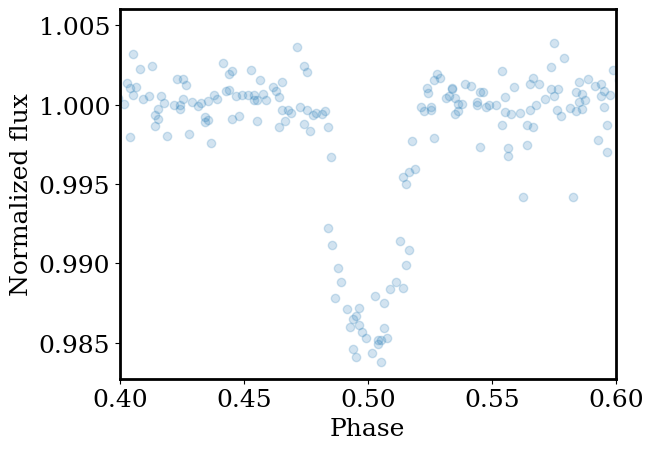

In [40]:
x_phased, y_phased, e_phased = phase_it(time, lc, lc_err, period_fit, phase+period_fit/2) # phase

_=plt.scatter(x_phased, y_phased,alpha=0.2)

plt.ylabel('Normalized flux')
plt.xlabel('Phase')
plt.xlim(0.4,0.6)
plt.show()

We can now model the transit to determine the planet's size!

In [41]:
def transit_model(phase, depth, duration, ingress):
    
    def norm(x):
        return (x-x.min()) / (x.max() - x.min())
    
    model = np.ones_like(phase)
    
    start = 0.5 - duration/2 - ingress
    end   = 0.5 + duration/2 + ingress
    
    
    C_ingress = (phase > start) & (phase < 0.5 - duration/2)
    C_egress  = (phase < end)   & (phase > 0.5 + duration/2)
    
    if len(C_ingress[C_ingress])>3:
        model[C_ingress] = 1 - depth * norm(phase[C_ingress])
        
    if len(C_egress[C_egress])>3:
        model[C_egress]  = (1-depth) + depth * norm(phase[C_egress]) 
    
    model[np.abs(phase-0.5)<duration/2] = 1-depth
    
    return model

def residual_transit_model(theta, phase, lc):
    depth, duration, ingress = theta
    
    model = transit_model(phase, depth, duration, ingress)
    
    return np.sum( np.power(model - lc,2) )

Try changing the transit depth, duration, and ingress time to fit the observed shape.

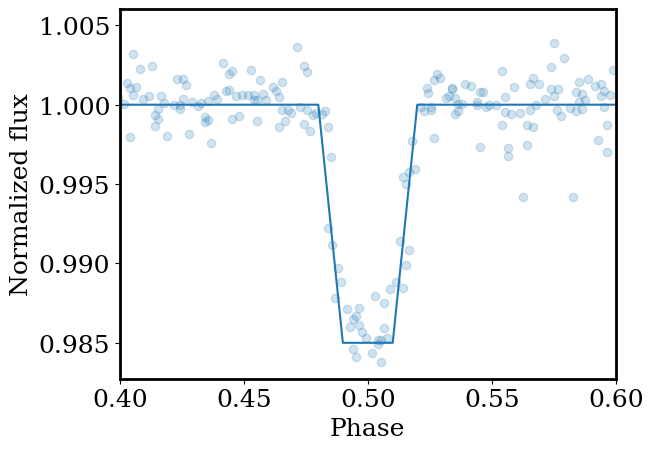

In [42]:
x_phased, y_phased, e_phased = phase_it(time, lc, lc_err, period_fit, phase+period_fit/2) # phase

xp = np.linspace(0,1,10000)
yp = transit_model(xp, 0.015, 0.02, 0.01)

_=plt.scatter(x_phased, y_phased,alpha=0.2)
_=plt.plot(xp,yp)

plt.ylabel('Normalized flux')
plt.xlabel('Phase')
plt.xlim([0.4,0.6])
plt.show()

Let's now try a more robust search method.

In [43]:
out = scipy.optimize.differential_evolution(residual_transit_model, 
                          bounds   = [
                              (0,0.02), 
                              (0,0.05), 
                              (0,0.05)],
                          args = (x_phased, y_phased),
            )


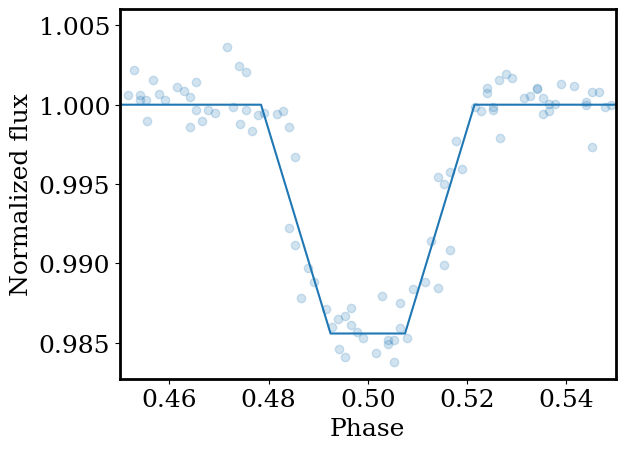

In [44]:
xp = np.linspace(0,1,1000)
yp = transit_model(xp, *out.x)

_=plt.scatter(x_phased, y_phased,alpha=0.2)
_=plt.plot(xp,yp)

plt.ylabel('Normalized flux')
plt.xlabel('Phase')
plt.xlim([0.45,0.55])
plt.show()

The transit depth is related to the planet's and star's sizes via:
$$\delta = (R_p / R_\star)^2$$

In [45]:
R_sun_to_jup  = 9.95 # R_jup
R_star = radius_star_tess * R_sun_to_jup

depth = out.x[0]

Rp = np.sqrt(depth) * R_star # jup

print(f'Found radius: {Rp:.3} R_jupiter')
print(f'Published radius: {radius_planet_tess:.3} R_jupiter')

Found radius: 1.4 R_jupiter
Published radius: 1.29 R_jupiter
